In [28]:
import json
import pandas as pd
import osmnx as ox
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join
from datetime import timedelta
from itertools import product
import random


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.spatial import cKDTree
from scipy.special import factorial


In [29]:
input_path = join("io", "input")
output_path = join("io", "output")
experiments_path = join("io", "experiments")
plots_path = join(experiments_path, "plots")

In [30]:
def generate_passenger_demand(stops_df, poi_df, output_path, date="2025-01-09"):
    """
    Generates a simulated probability distribution for passenger demand at each stop
    for every minute between 07:00 AM and 11:45 PM. The length of the distribution varies,
    with most distributions being 10-20 long, and only extreme cases reaching 50.

    Parameters:
        stops_df (pd.DataFrame): DataFrame with bus stop locations [id, latitude, longitude]
        poi_df (pd.DataFrame): DataFrame with POI locations [poi_name, latitude, longitude]
        date (str): Date for simulation (YYYY-MM-DD format)

    Returns:
        pd.DataFrame: Columns ['stop_id', 'timestamp', 'passenger_demand_distribution']
    """

    # Define operational time range
    start_time = datetime.strptime(date + " 07:00:00", "%Y-%m-%d %H:%M:%S")
    minutes_per_day = 1005  # From 07:00 to 23:45
    time_series = [start_time + timedelta(minutes=i) for i in range(minutes_per_day)]
    
    # Construct KDTree for POI proximity calculations
    poi_coords = np.array(poi_df[['latitude', 'longitude']])
    stop_coords = np.array(stops_df[['latitude', 'longitude']])
    poi_tree = cKDTree(poi_coords)
    
    # Compute POI influence score for each stop
    distances, _ = poi_tree.query(stop_coords, k=1)  # Find nearest POI for each stop
    poi_influence = np.exp(-distances / 2)  # Exponential decay function for influence
    
    # Rush hour multipliers
    def rush_hour_factor(t):
        if 8 <= t.hour < 9 or 16 <= t.hour < 18 or 20 <= t.hour < 21:
            return 2.5  # Peak times
        elif 7 <= t.hour < 10 or 15 <= t.hour < 19:
            return 1.5  # Mild rush hour
        else:
            return 1.0  # Normal hours

    # Create demand probability distributions
    data = []
    for i, stop in stops_df.iterrows():
        stop_id = stop["id"]
        stop_base_demand = np.random.uniform(0.2, 1.0) * poi_influence[i]  # Base demand per stop
        
        for t in time_series:
            rush_factor = rush_hour_factor(t)
            expected_passengers = np.random.poisson(lam=5 * stop_base_demand * rush_factor)
            expected_passengers = max(1, min(expected_passengers, 50))  # Ensure at least 1 expected passenger
            
            # Determine the max passenger count dynamically (most values between 10-20)
            max_passengers = min(50, max(5, int(np.random.normal(15, 5) * rush_factor * poi_influence[i])))
            
            # Generate probability distribution only up to `max_passengers`
            counts = np.arange(0, max_passengers + 1)
            lambda_param = expected_passengers / 3  # Scale lambda
            probs = np.exp(-lambda_param) * (lambda_param ** counts) / factorial(counts)
            
            # Ensure no absolute zero demand
            probs += 1e-6  # Small constant to avoid zeros
            probs /= probs.sum()  # Normalize to sum to 1
            
            # Store results
            data.append([stop_id, t, probs.tolist()])
    
    # Create DataFrame
    demand_df = pd.DataFrame(data, columns=["stop_id", "timestamp", "passenger_demand_distribution"])
    demand_df.to_csv(join(output_path, "interm_passenger_demand.csv"), sep=',', encoding='utf-8', index=False)
    return demand_df


In [31]:
def plot_random_distribution(demand_df):
    """
    Selects a random row from the demand DataFrame and plots the probability distribution.
    
    Parameters:
        demand_df (pd.DataFrame): DataFrame containing ['stop_id', 'timestamp', 'passenger_demand_distribution']
    """
    random_number = random.randint(1, 100)
    # Select a random row
    random_row = demand_df.sample(n=1).iloc[0]
    
    # Extract data
    stop_id = random_row["stop_id"]
    timestamp = random_row["timestamp"]
    distribution = random_row["passenger_demand_distribution"]
    
    # Plot the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution, color='blue', alpha=0.7)
    plt.xlabel("Passenger Count")
    plt.ylabel("Probability")
    plt.title(f"Passenger Demand Distribution\nStop: {stop_id} | Time: {timestamp}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(plots_path + "/passenger_demand_distribution_" + str(stop_id) + "_" + str(random_number) + ".pdf")
    plt.show()

In [32]:
stops_df = pd.read_csv(join(input_path, "base_stops.csv"), encoding='utf-8', sep=';')
poi_df = pd.read_csv(join(input_path, "base_point_of_interest.csv"), encoding='utf-8', sep=',')
demand_df = generate_passenger_demand(stops_df, poi_df, output_path)

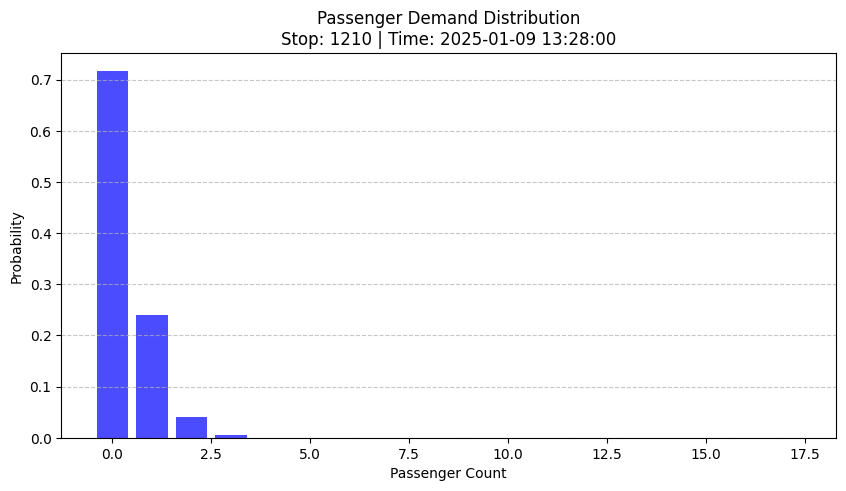

In [33]:
plot_random_distribution(demand_df)